# The Cross-Entropy Method

## Topics:

* The taxonomy of reinforcement learning methods
* The practical side of the cross-entropy method
* How the cross-entropy method works in CartPole in Gym
* The math behind the cross-entropy method

## The strengths of the cross-entropy method

* Simple to implement in PyTorch
* the method has good convergence
* the cross-entropy method usually works very well in simple environments that
    * don't require complex, multistep policies to be learned and discovered
    * have short episodes with frequent rewards

## The taxonomy of RL methods

<img src="https://yu.instructure.com/files/3709474/download?download_frd=1" width="750" align="center">

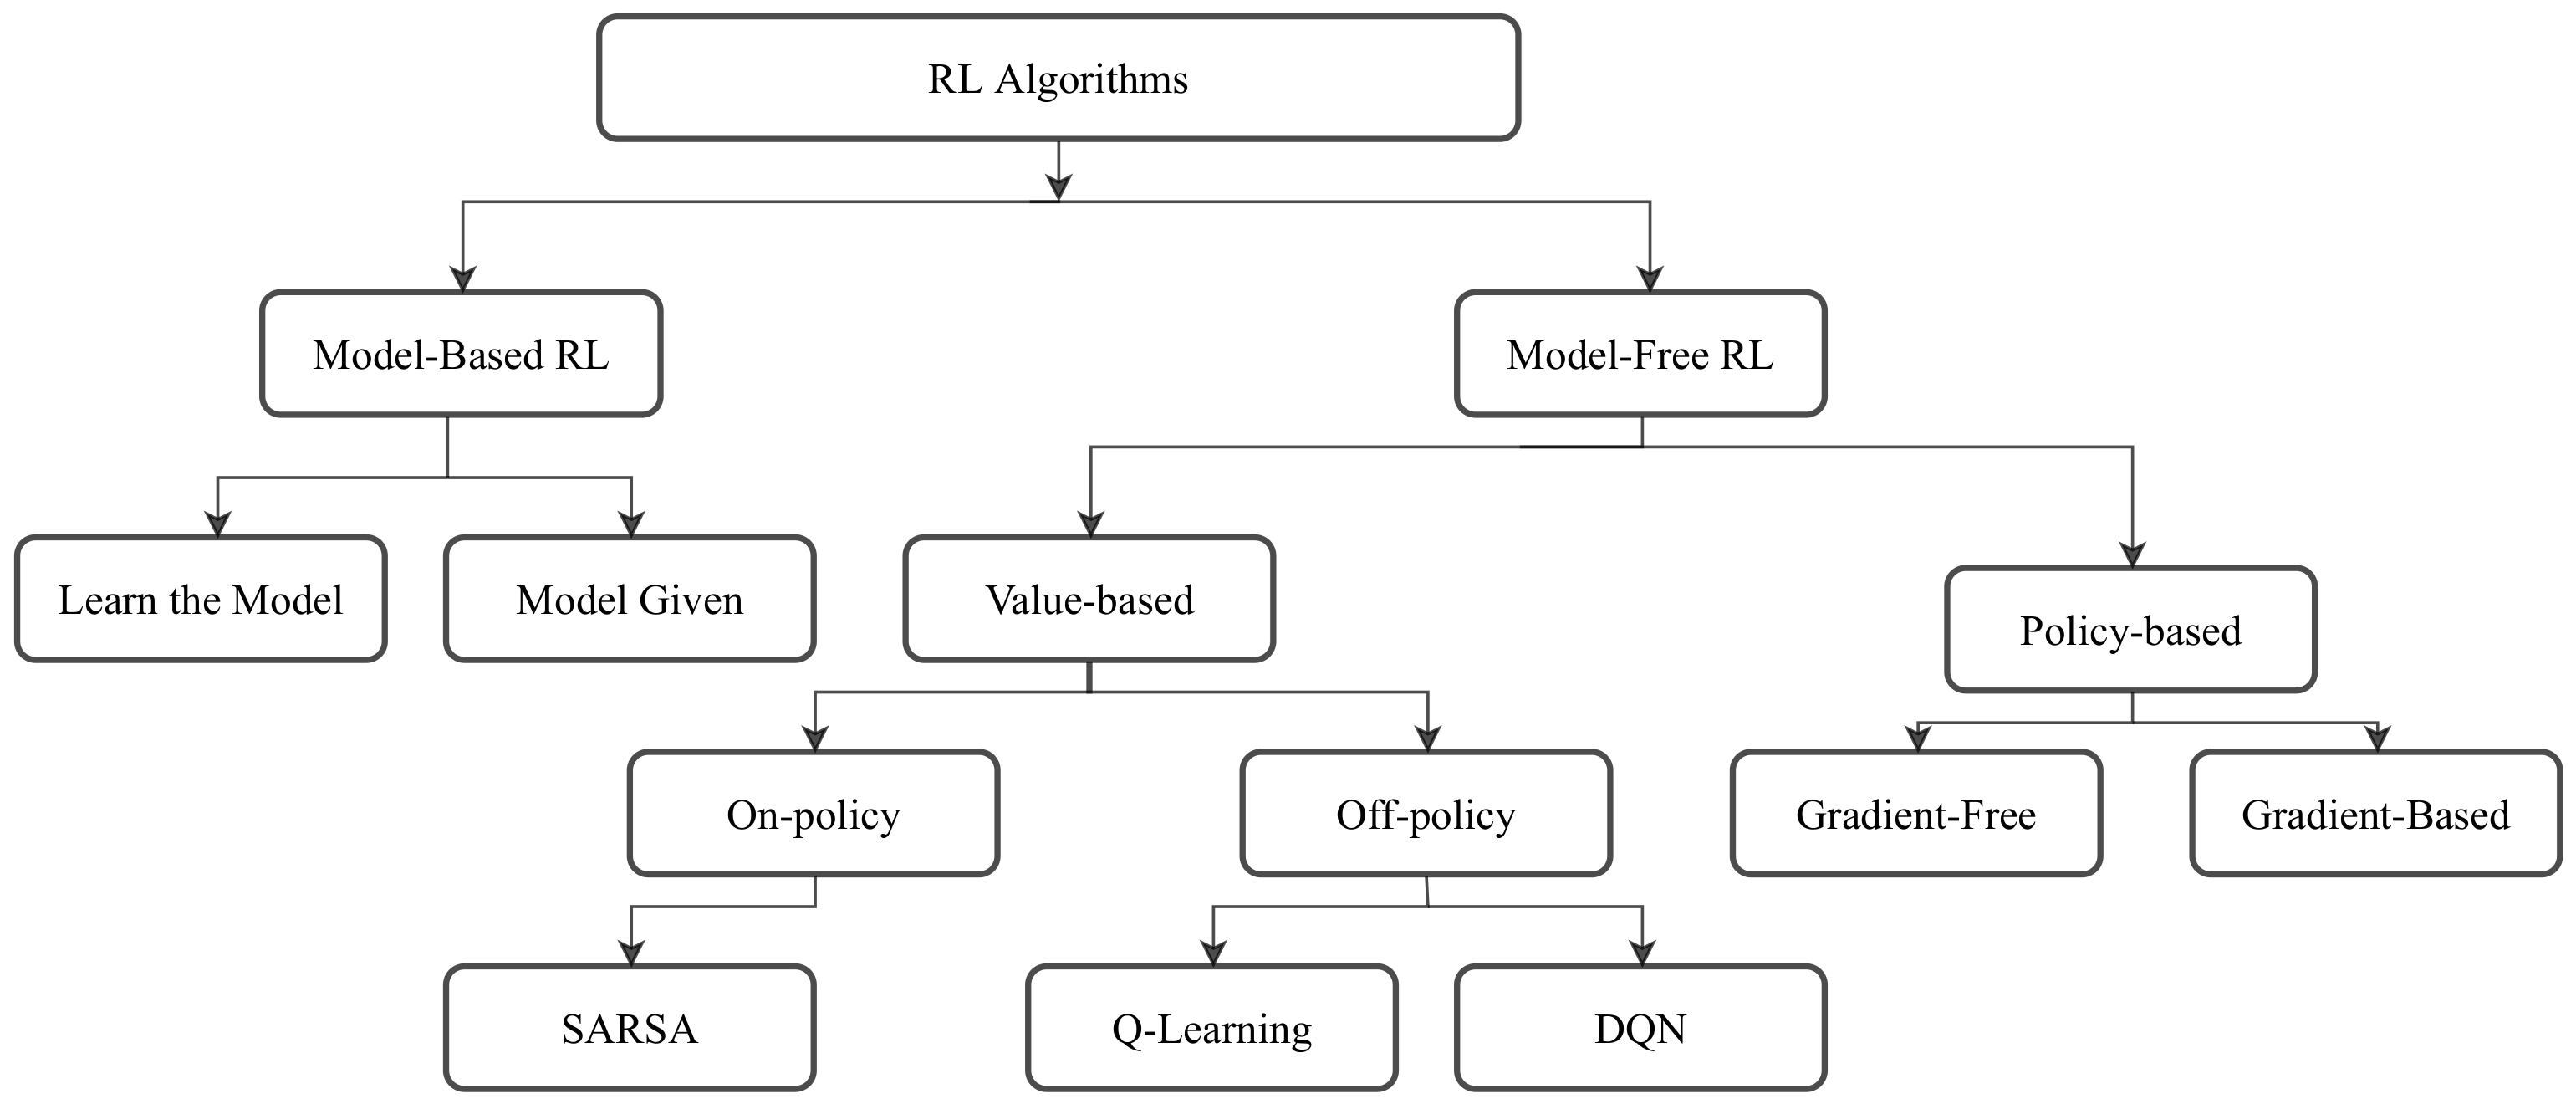

### model-based:
* Try to **predict what the next observation and/or reward will be**. 
* Based on this prediction, the agent tries to choose the best possible action to take
* very often making such predictions multiple times to look more and more steps into the future.

* used in deterministic environments, such as board games with strict
rules
* such as Monte-Carlo Tree Search (MCTS)

### model-free: 

* the method **doesn't build a model of the environment or reward**; 
* it's hard
to build good models of complex environments with rich observations
* it just directly connects observations to actions (or values
that are related to actions). 
* In other words, the agent takes current observations and
does some computations on them, and the result is the action that it should take.
* The most active area of research in recent years
* In this course we focus on model-free methods

### Two categories under model-free

* **policy-based methods directly approximate the policy of the agent**
    * what actions the agent should carry out at every step. 
    * The policy is usually represented by a **probability distribution over the available actions**
    
* **value-based methods calculates the value of every possible action and chooses the
action with the best value.**
    * don't compute the probability of actions 

### on-policy and off-policy under value-based methods

The major differences are:

**On-Policy:**

* **Learning from Current Policy:** On-policy methods learn from the policy currently in use. They aim to optimize the policy that generates data for learning.
* **Exploration within the Current Policy:** They explore and make decisions based on the policy being improved. This can limit exploration beyond the current policy's boundaries.
* **Examples:** SARSA (State-Action-Reward-State-Action) is an on-policy algorithm commonly used for control tasks in RL.
* **Sensitivity to Exploration:** On-policy methods may require more careful exploration strategies, as exploration directly affects the data used for policy improvement.
* **Typically Less Sample-Efficient:** On-policy algorithms often require more samples to converge to an optimal policy.


**Off-Policy:**

* **Learning from Past Data:** Off-policy methods learn from past experience, allowing the agent to explore freely without the need to adhere to the current policy.
* **Decoupled Exploration and Exploitation:** They can explore freely and separately from the current policy, which can lead to more efficient exploration.
* **Examples:** Q-learning is a classic off-policy algorithm used for value estimation and control tasks in RL.
* **Better Sample Efficiency:** Off-policy algorithms tend to be more sample-efficient because they can reuse and learn from previously collected data.
* **Data Reusability:** Off-policy methods can reuse data collected from previous policies, making them particularly useful in scenarios where exploration is costly or risky.


We will come back to this topic later in this course.

For now, off-policy method

* learn on historical data
    * obtained by a previous version of the agent
    * recorded by human demonstration
    * or just seen by the same agent several episodes ago

## With all the concepts above, what is cross-entropy method?

The cross-entropy method is **model-free, policy-based, and on-policy**


* It doesn't build any model of the environment; it just says to the agent
what to do at every step
* It approximates the policy of the agent
* It requires fresh data obtained from the environment

## The cross-entropy method in practice

* **Agent** is trying to accumulate as much total reward as possible by communicating with the environment.

* In ML, we can **implement agent as nonlinear trainable
function (neural network (NN))**, which maps the agent's input (observations from the environment) to
some output


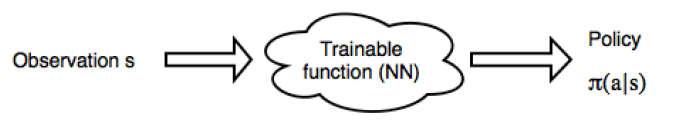


* As our cross-entropy method
is policy-based, our **nonlinear function (neural network (NN)) produces the policy,**
which basically says for every observation which action the agent should take.

* In practice, the policy is usually represented as a **probability distribution over
actions, which makes it very similar to a classification problem**, with the amount
of classes being equal to the amount of actions we can carry out.

## Let's simplify the above into three steps:

1. it needs to pass an observation
from the environment to the NN, 
2. get a probability distribution over actions, 
3. and
perform random sampling using the probability distribution to get an action to
carry out.

## Episodes:

* Every episode is
**a sequence of observations that the agent has got from the environment, actions it
has issued, and rewards for these actions.**

* For every episode, we can **calculate the total reward** that the agent
has claimed

* Reward can be discounted or not discounted (we will come back to this topic later. Let's assume no discount for now.)

* So, total reward in each episode is just a sum of all rewards.

* This total reward shows how good this episode was for the agent.

* For example

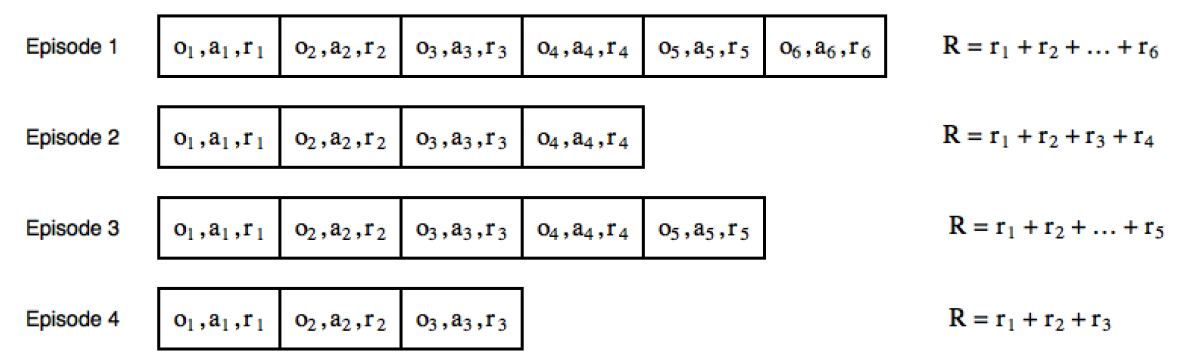

## The basic idea behind the cross-entropy method

**The core of the cross-entropy method is to throw away bad episodes and train on better ones.**

Steps:

1. Play N number of episodes using our current model and environment.
2. Calculate the total reward for every episode and decide on a reward
boundary. Usually, we use some percentile of all rewards, such as 50th
or 70th.
3. Throw away all episodes with a reward below the boundary.

4. Train on the remaining "elite" episodes using observations as the input and
issued actions as the desired output.
5. Repeat from step 1 until we become satisfied with the result.

#### In short, it is an Evolutionary Algorithm. Some individuals are sampled from a population and only the best ones govern the characteristics of future generations.

### The intuition:

* One simple way of doing this would be to take a bunch of inputs, see the outputs produced, 
* choose the inputs that have led to the best outputs 
* and tune them till you are satisfied with the outputs you see. 

This is essentially what the cross-entropy method does.

**Question**: How do you find your best strategy to play with a row of bandit slot machines in casino?
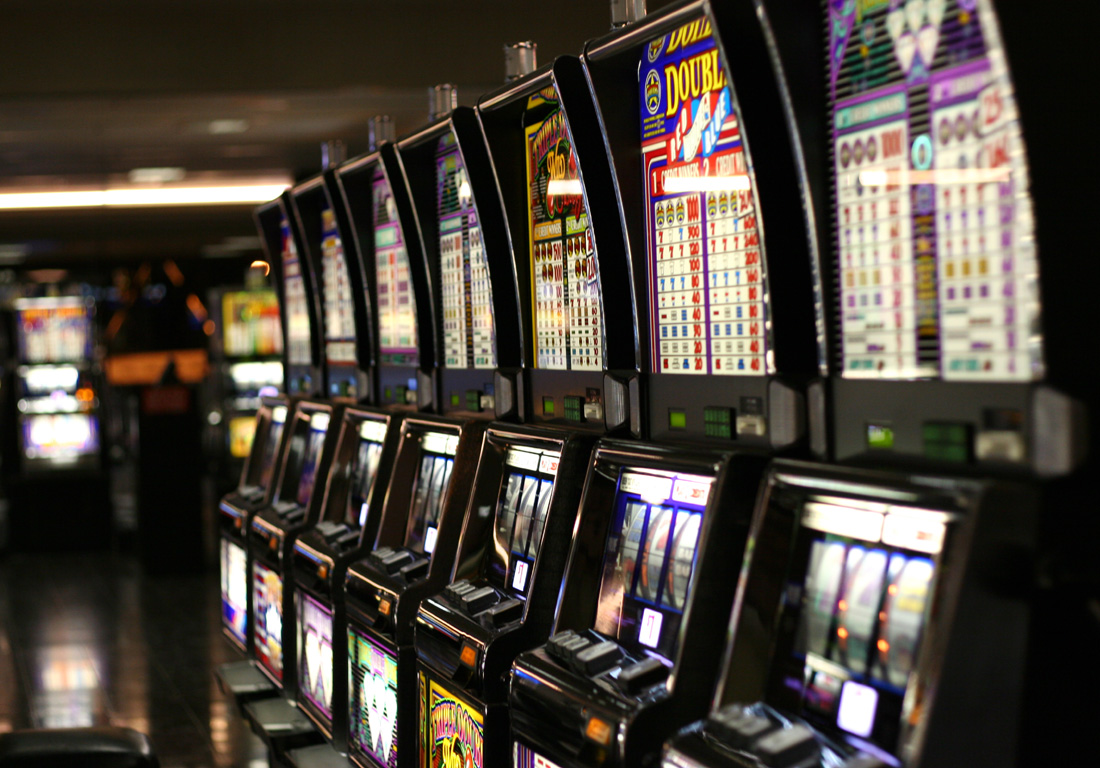

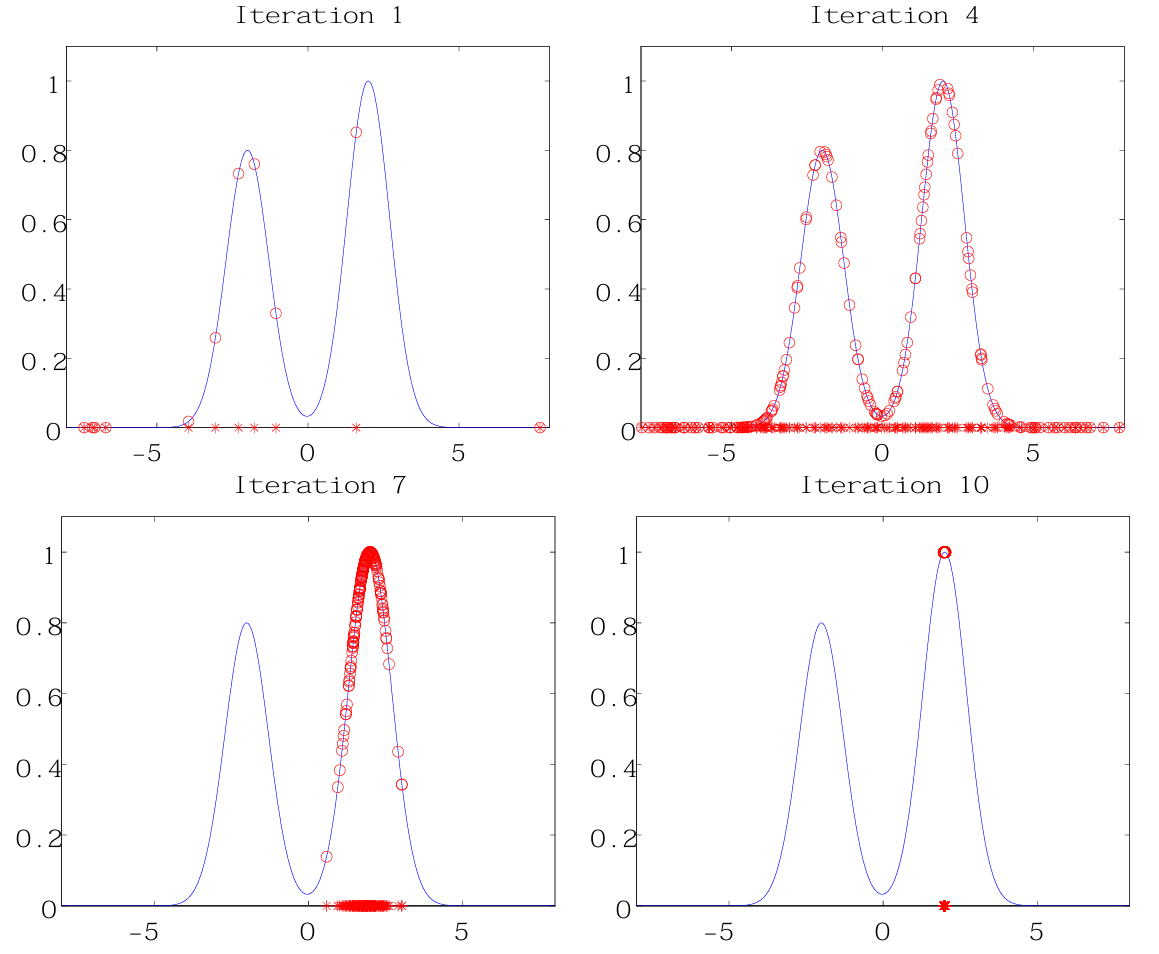

## Revisit the CartPole problem

* The observation (aka, the state) from the environment consists of four possible values [cart position, cart velocity, pole angle, pole angular velocity] and the agent should choose one from two possible actions [left, right] for next step.
* The reward +1 is given at every timestep if the pole remains upright. 
* The goal is to prevent the pole from falling over(maximize total reward). If total reward > 199, the problem is considered solved.

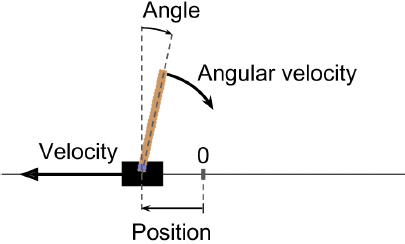

#### If you haven't installed the packages, run the commands in anaconda prompt

pip install gym

pip install tensorboardX

pip install tensorboard

In [1]:
import gym
from collections import namedtuple
import numpy as np
from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
env = gym.make("CartPole-v1")
# env = gym.wrappers.Monitor(env, directory="mon", force=True)
obs_size = env.observation_space.shape[0]
n_actions = env.action_space.n

### Build the "Deep Learning" model in PyTorch

* one-hidden-layer NN
* with rectified linear unit (ReLU) 
* and 128 hidden neurons

What the model does is

* it takes a single observation from the
environment as an input vector 
* and outputs a number for every action we can
perform. 
* The output from the NN is a probability distribution over actions, 
* so
a straightforward way to proceed would be to include softmax nonlinearity after
the last layer, but we add softmax and crossentropy later

* we need to remember to apply
softmax every time we need to get probabilities from our NN's output

In [3]:
# count of neurons in the hidden layer
HIDDEN_SIZE = 128 

# the count of episodes we play on every iteration
BATCH_SIZE = 16   

# the percentile of episodes' total rewards that we use for "elite" episode filtering
# We will take the 70th percentile, which means that we will leave the top 30% of episodes sorted by reward        
PERCENTILE = 70 

class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_actions)
        )

    def forward(self, x):
        return self.net(x)

### Create an instance of such NN

* Initial weights from a random distribution. 
* This distribution is generally chosen to be a **Gaussian distribution with mean μ and variance σ²**
* You can choose any distribution that you believe the weights are from.
* Here we just take whatever the default initial weights in memory as a starting point.

In [4]:
net = Net(obs_size, HIDDEN_SIZE, n_actions)


In [5]:
from torchsummary import summary
summary(net, (16,4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 16, 128]             640
              ReLU-2              [-1, 16, 128]               0
            Linear-3                [-1, 16, 2]             258
Total params: 898
Trainable params: 898
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [6]:
net.state_dict()

OrderedDict([('net.0.weight',
              tensor([[-0.3924, -0.2001,  0.4886,  0.3051],
                      [-0.0295,  0.2700, -0.4695, -0.4380],
                      [ 0.1434, -0.2400,  0.1165,  0.2880],
                      [ 0.3826, -0.1733,  0.0409,  0.3854],
                      [-0.0871,  0.3626, -0.2045, -0.3033],
                      [-0.0708, -0.3539, -0.1081,  0.3968],
                      [ 0.1420, -0.3410, -0.4674, -0.3302],
                      [-0.3184, -0.4880,  0.1420,  0.1805],
                      [ 0.4728, -0.2919,  0.0883, -0.0983],
                      [-0.1950, -0.2914, -0.0373, -0.1166],
                      [-0.3444,  0.4580,  0.3651,  0.3099],
                      [ 0.0093,  0.1116, -0.3129,  0.3015],
                      [ 0.4202,  0.1757,  0.1887, -0.2570],
                      [ 0.0225, -0.2096, -0.3989,  0.4093],
                      [-0.3862,  0.2053,  0.2096,  0.4405],
                      [ 0.4539,  0.3086,  0.4760, -0.1607],
          

## Two helper classes

Two named tuples from the collections package in the standard library
* **EpisodeStep:** This will be used to represent one single step that our agent
made in the episode, and it stores the observation from the environment
and what action the agent completed. We will use episode steps from "elite"
episodes as training data.
* **Episode:** This is a single episode stored as total undiscounted reward and
a collection of EpisodeStep.

In [7]:
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation', 'action'])
Episode = namedtuple('Episode', field_names=['reward', 'steps'])

### A side topic: Some notes about namedtuple

* A named tuple is a tuple, so it does everything that a tuple can. 
* However, it is beyond a normal Python tuple. It is more like a “struct” in other programming languages such as C++. 
* It is a specific subclass of a tuple that is programmatically created to your specification with named fields and fixed length.

In [8]:
from collections import namedtuple

* define a namedtuple "User", which has attributes "name", "sex", and "age"

In [9]:
User = namedtuple('User', ['name', 'sex', 'age'])

* create a User object "user". Similar to an instance from struct in C++.

In [10]:
user = User(name='david', sex='male', age=21)

* You can also make such an instance through a list of the values, using `_make()` method

In [11]:
user = User._make(['david', 'male', 21])

* Let's check the object content

In [12]:
print(user)

User(name='david', sex='male', age=21)


* You can also access each of attributes by the name

In [13]:
user.name, user.sex, user.age

('david', 'male', 21)

* Use `_replace()` to modify the attributes

In [14]:
user = user._replace(age=22)
user

User(name='david', sex='male', age=22)

* Use `_asdict()` to convert it to dict

In [15]:
user._asdict()

{'name': 'david', 'sex': 'male', 'age': 22}

## Now we are ready to generate batches with episodes

* let the agent pick actions from the policy network based on these weights
* run the agent through an episode 
* collect the rewards generated by the environment

The parameters:
* env - the environment (the Env class instance from the Gym library)
* net - our NN (the deep learning part)
* batch_size - the count of episodes it should generate on every iteration.

In [29]:
def iterate_batches(env, net, batch_size):
    batch = [] # accumulate the batch (which is a list of Episode instances)
    episode_reward = 0.0 # the reward counter for the current episode
    episode_steps = [] # the current episode's list of steps (the EpisodeStep objects)
    obs, _ = env.reset() # New version of gym has new format of return. Reset to start the episode.
    sm = nn.Softmax(dim=1) # we need to remember to apply softmax every time we need to get probabilities from our NN's output

    
    while True:
        # At every iteration, we convert our current observation to a PyTorch tensor 
        # and pass it to the NN to obtain action probabilities.
        
        # convert a vector of four numbers in CartPole to tensor of size 1x4 because PyTorch expects a batch. 
        obs_v = torch.FloatTensor([obs]) # from 1D to 2D in tensor
    
        # don't forget the softmax
        # convert the NN's output to a probability distribution of actions
        act_probs_v = sm(net(obs_v))      
        # pytorch returns tensors. Once we come back to python world, we need to convert to numpy array to get values.
        act_probs = act_probs_v.data.numpy()[0] # retrieve values from 2D tensor
        # random sampling by probs
        action = np.random.choice(len(act_probs), p=act_probs) 
        
        # move on to next step with the choosen action
        next_obs, reward, terminated, truncated, info = env.step(action); is_done = truncated or terminated # new version of gym
        
        # accumulate the reward to the current episode, no matter what value it is
        episode_reward += reward
        
        # Log this step. 
        step = EpisodeStep(observation=obs, action=action)  #########
        episode_steps.append(step)
        
        # The current episode is over. Log the total reward and ready for next new episode.
        # Steps: 
        # 1. We append the finalized episode to the batch, 
        # 2. saving the total reward (as the episode has been completed and we have accumulated all the reward) 
        # 3. and steps we have taken. 
        # 4. Then we reset our total reward accumulator and clean the list of steps. 
        # 5. After that, we reset our environment to start over.
        if is_done:
            e = Episode(reward=episode_reward, steps=episode_steps) ########
            batch.append(e)
            episode_reward = 0.0
            episode_steps = []
            next_obs, _ = env.reset()
            
            # Return a batch to train NN in another function.
            # The NN will have different, slightly better (hopefully) behavior.
            if len(batch) == batch_size:
                yield batch # yield the entire batch of episodes as a generator
                batch = []  # then start the next batch from empty list
                
        # Continue the game to next iteration if it is still alive.
        obs = next_obs

## The core of the cross-entropy method

* from the given batch of episodes and percentile value, it calculates a boundary reward
* which is used to filter "elite" episodes to train on

Paramaters:

* batch - the batch from `iterate_batches()`
* percentile - pre-defined value as "elite" episode filtering

Steps:

* use NumPy's percentile function to obtain the boundary reward,
* i.e., from the list of values and the desired percentile, calculates the percentile's value. 
* we also calculate the mean reward to monitor the performance improvement.

In [17]:
def filter_batch(batch, percentile):
    rewards = list(map(lambda s: s.reward, batch)) # retrieve all total rewards for each episode
    reward_bound = np.percentile(rewards, percentile) # It is like the "honor college" cut-off point
    reward_mean = float(np.mean(rewards)) # just for monitoring purpose. Not used in training.

    # Enroll the elite episodes to "honor college"
    train_obs = []
    train_act = []
    for reward, steps in batch:
        if reward < reward_bound:
            continue
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))

    # convert to tensor then be used in training.
    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    
    return train_obs_v, train_act_v, reward_bound, reward_mean

## We are almost ready for training NN

### Set the loss function and optimizer before training

* we can use the PyTorch class `nn.CrossEntropyLoss`
* It **combines both softmax and cross-entropy** in a single, more numerically
stable expression

In [18]:
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=net.parameters(), lr=0.01)

### Write logs for tensorboard 

In [19]:
writer = SummaryWriter(comment="-cartpole") # the summary writer for TensorBoard

## Now we are ready. Let's start training

* The idea of this is to reinforce our NN to carry out those "elite" actions that have led to good rewards
* Update the weights so that they will generate rewards closer to the elite groups.
* The optimal solution won't happen in one iteration, so we need to train many times until the weights come to the satisifying values.

In [20]:
for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
    obs_v, acts_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
    optimizer.zero_grad()
    action_scores_v = net(obs_v)
    loss_v = objective(action_scores_v, acts_v)
    loss_v.backward()
    optimizer.step()
    print("%d: loss=%.3f, reward_mean=%.1f, rw_bound=%.1f" % (
        iter_no, loss_v.item(), reward_m, reward_b))
    writer.add_scalar("loss", loss_v.item(), iter_no)
    writer.add_scalar("reward_bound", reward_b, iter_no)
    writer.add_scalar("reward_mean", reward_m, iter_no)
    if reward_m > 199:
        print("Solved!")
        break

C:\Users\srikr\AppData\Local\Temp\ipykernel_4792\3094926170.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  obs_v = torch.FloatTensor([obs]) # from 1D to 2D in tensor
C:\Users\srikr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0: loss=0.689, reward_mean=22.8, rw_bound=23.0
1: loss=0.677, reward_mean=31.6, rw_bound=39.5
2: loss=0.662, reward_mean=26.2, rw_bound=28.5
3: loss=0.661, reward_mean=38.3, rw_bound=39.5
4: loss=0.628, reward_mean=33.2, rw_bound=42.5
5: loss=0.632, reward_mean=41.9, rw_bound=45.5
6: loss=0.613, reward_mean=50.0, rw_bound=61.0
7: loss=0.603, reward_mean=52.7, rw_bound=57.0
8: loss=0.588, reward_mean=50.1, rw_bound=61.0
9: loss=0.593, reward_mean=69.6, rw_bound=84.5
10: loss=0.585, reward_mean=79.8, rw_bound=84.5
11: loss=0.573, reward_mean=71.5, rw_bound=87.5
12: loss=0.556, reward_mean=77.4, rw_bound=91.0
13: loss=0.572, reward_mean=66.9, rw_bound=77.5
14: loss=0.577, reward_mean=74.4, rw_bound=78.5
15: loss=0.570, reward_mean=86.2, rw_bound=81.0
16: loss=0.545, reward_mean=59.2, rw_bound=79.0
17: loss=0.549, reward_mean=81.0, rw_bound=86.5
18: loss=0.547, reward_mean=75.9, rw_bound=87.0
19: loss=0.525, reward_mean=81.4, rw_bound=98.5
20: loss=0.527, reward_mean=97.0, rw_bound=110.5
2

### Don't forget to close the log writer.

In [21]:
writer.close()

## View the logs

Run the command to launch the logs

tensorboard --logdir=runs

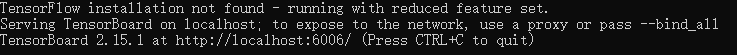

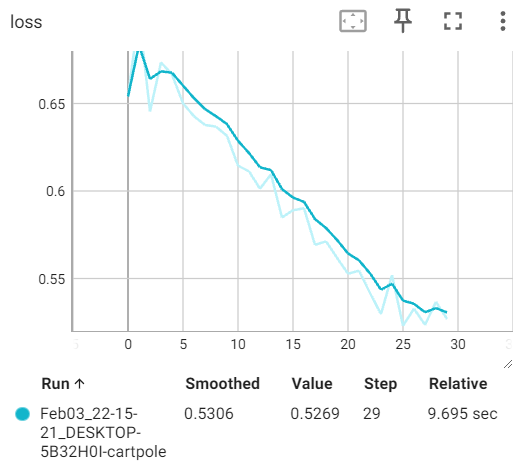

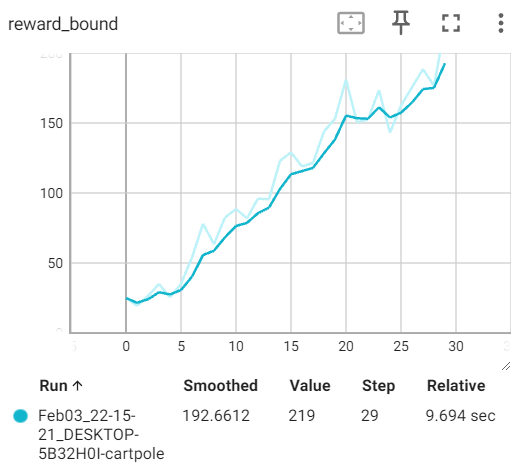

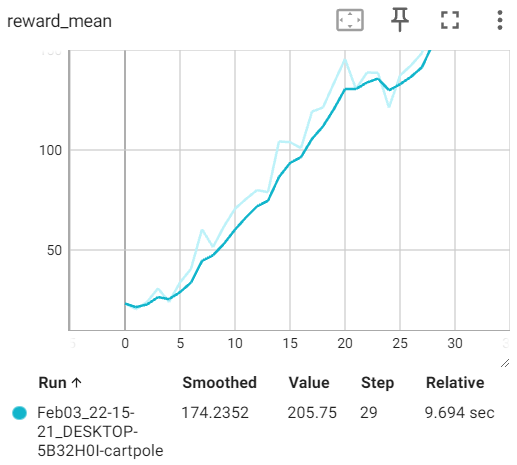

## Notes

* The NN has learned how to play the environment purely from observations and rewards, without any
interpretation of observed values.
* The environment could be others as long as it has observation and reward.
* The implementation doesn't depend on environment details.
* Using the trained model, the pole can stand up forever if not the 200 steps limit. 

<img src="https://yu.instructure.com/files/3709480/download?download_frd=1" width="750" align="center">

## The math behind the cross-entropy method

* The basis of the cross-entropy method lies in the importance sampling theorem but for a different goal.
* Assume we have a very limited budget and it’s infeasible for us to sample a large amount of examples or run many Monte Carlo trials to estimate the expectation.

$$\large \begin{align}
\mathbb{E}_{x\sim p(x)}[H(x)]&=\int_{x}^{} p(x)H(x)dx\\ 
&=\int_{x}^{}q(x)\frac{p(x)}{q(x)}H(x)dx\\ 
&=\mathbb{E}_{x\sim q(x)}\left[  \frac{p(x)}{q(x)}H(x)\right]
\end{align}
$$
where

* $H(x)$ is a reward value obtained by some policy, $x$
* $p(x)$ is a distribution of all possible policies.

### This formula says: The $p(x)$ probability weighted average of $H(x)$ is equal to the $q(x)$ probability weighted average of $H(x)$ times the ratio of $p(x)/q(x)$ densities.

The goal

* Apparently the idea is to search all possible policies to maximize our reward, but it is too slow.
* because $p(x)$ is difficult to sample from.
* instead we want to find a way to approximate $p(x)H(x)$ by $q(x)$

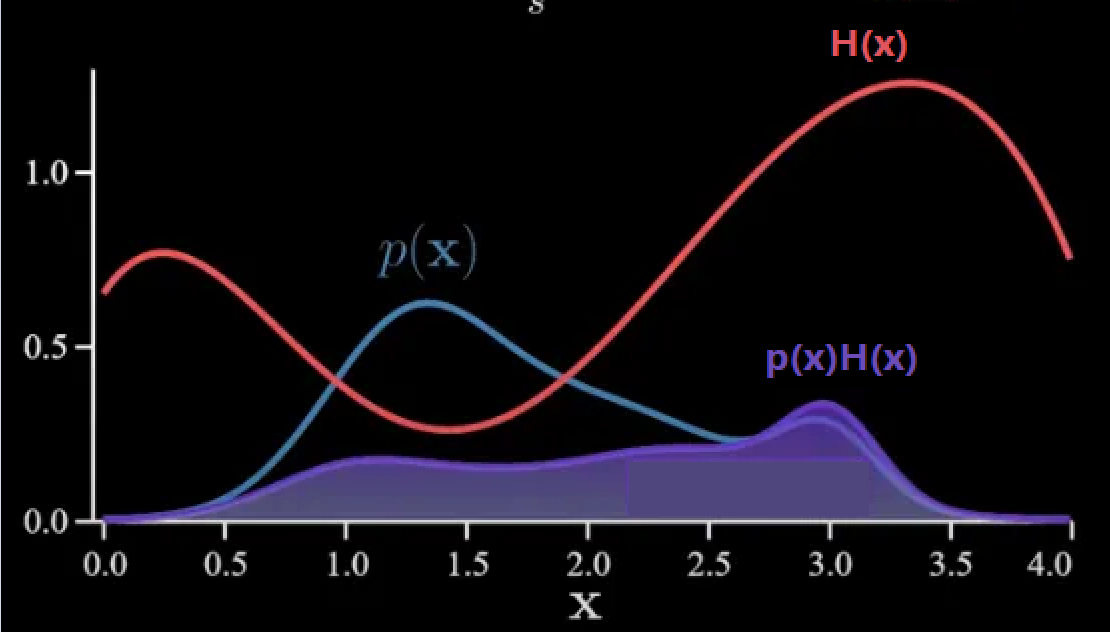

* in other words, we want $q(x)$ to be high where $|p(x)H(x)|$ is high, so that **the variance of the $\mathbb{E}_{x\sim p(x)}[H(x)]$ will be smaller.**

$$\large \begin{align}
\frac{1}{N} Var_q \left[\frac{p(x)}{q(x)} H(x) \right] \lt \frac{1}{N} Var_p \left[ H(x) \right]
\end{align}$$

* $q(x)$ should be easy to evaluate and sample from. 
* This is called **importance sampling**
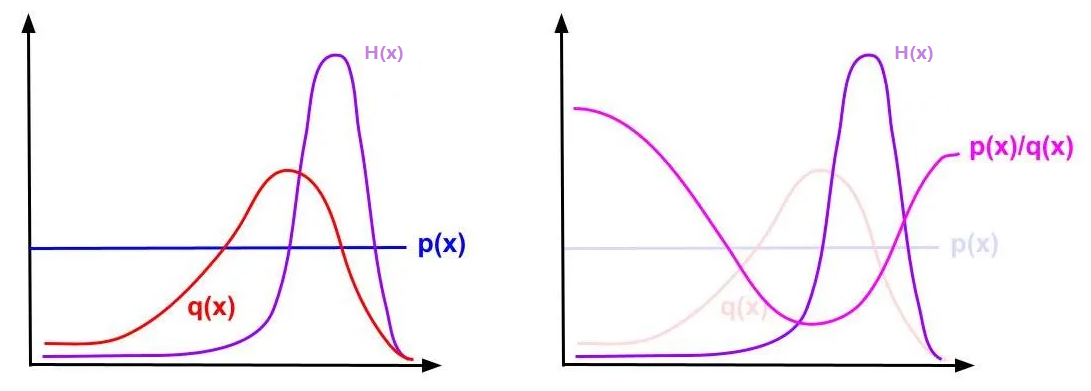
* In our case, $q(x)$ is the policy $\pi_{i}(a|s)$ we want to optimize and sample from. 
* Mathematically, we want to minimize the distance between the two functions $p(x)H(x)$ and $q(x)$
* In other words, if we pick a few samples from $q(x)$, we will more likely to hit the high value region of $p(x)H(x)$, i.e., **higher total reward from sampling.**
* The distance between two probability distributions is calculated by **Kullback-Leibler (KL) divergence**

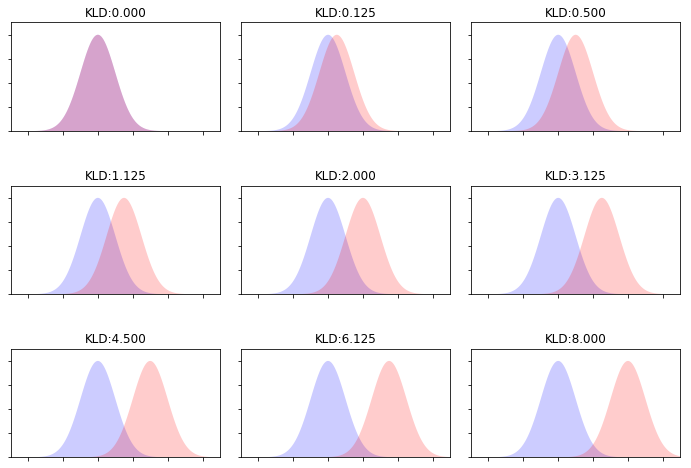
* Note: Kullback-Leiblier divergence is asymmetrical i.e. generally $KL(p_1(x)\parallel p_2(x))$ is not equal $KL(p_2(x)\parallel p_1(x))$.

$$\large \large \begin{align}
KL(p_1(x)\parallel p_2(x))&=\mathbb{E}_{x\sim p_1(x)} \log \frac{p_1(x)}{p_2(x)}\\
&=\mathbb{E}_{x\sim p_1(x)}\left[  \log p_1(x)\right] - \mathbb{E}_{x\sim p_1(x)}\left[  \log p_2(x)\right]
\end{align} $$

* Two terms: **entropy** (aka self-entropy) and **cross-entropy**

* The optimization: in order to minimize the distance between $p_1(x)$ and $p_2(x)$, we need to **minimize the cross-entropy**.

* Let's combine both formulas and we only care about the second term


$$\large 
\large \begin{align}
KL(p(x)H(x)\parallel q(x))&=\mathbb{E}_{x\sim p(x)H(x)} \log \frac{p(x)H(x)}{q(x)}\\
&=\mathbb{E}_{x\sim p(x)H(x)}\left[  \log p(x)H(x)\right] - \mathbb{E}_{x\sim p(x)H(x)}\left[  \log q(x)\right]\\
&=\mathbb{E}_{x\sim p(x)H(x)}\left[  \log p(x)H(x)\right] - \mathbb{E}_{x\sim p(x)}\left[H(x)  \log q(x)\right]\\
&=\mathbb{E}_{x\sim p(x)H(x)}\left[  \log p(x)H(x)\right] - \mathbb{E}_{x\sim q(x)}\left[  \frac{p(x)}{q(x)}H(x)\log q(x)\right]
\end{align}
$$

* In order to find $q(x)$ numerically, we can approximate $p(x)H(x)$ by $q(x)$ with an iterative algorithm

$$\large \begin{align}
q_{i+1}(x)&=\arg\min_{q_{i+1}(x)} - \mathbb{E}_{x\sim q_i(x)}\left[  \frac{p(x)}{q_i(x)}H(x)\log q_{i+1}(x)\right] 
\end{align}
$$


* Come back to our problem, we can simplify a lot

    * replace $H(x)$ with an indicator function, 
    * which is 1 when the reward for the episode is above the threshold and 0 when the reward is below.
    * So the policy update will look like this
    
    $$\large \begin{align}
\pi_{i+1}(a|s)&=\arg\min_{\pi_{i+1}} - \mathbb{E}_{z\sim \pi_i(a|s)}\left[\ R(z \ge \psi_i)\right] \log \pi_{i+1}(a|s)
\end{align}$$

    * In our case, the new policy is relatively close to the old policy, we can calculate the total rewards based on the old policy instead and reweight them according to the new policy. The rewards from the old policy make up the proposal distribution.
    

## Summary of cross-entropy method

* Sample episodes using the current policy (starting with some random initial policy) 
* then minimize the negative log likelihood of the most successful samples and our policy.
* Schematic view of the Cross-Entropy method.
* Simply put, we adjust the policy $\pi(a|s)$ little by little until the probability density matches the most rewarding area.

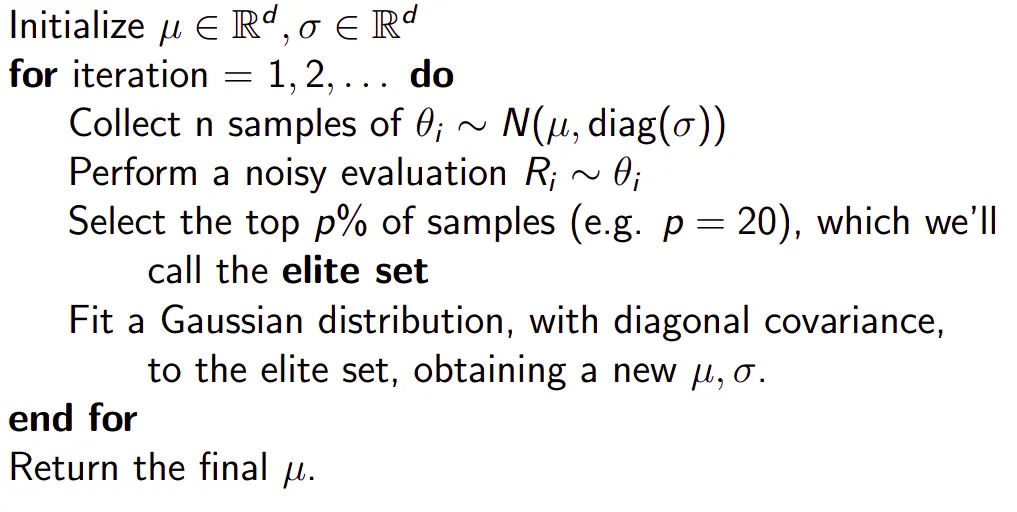

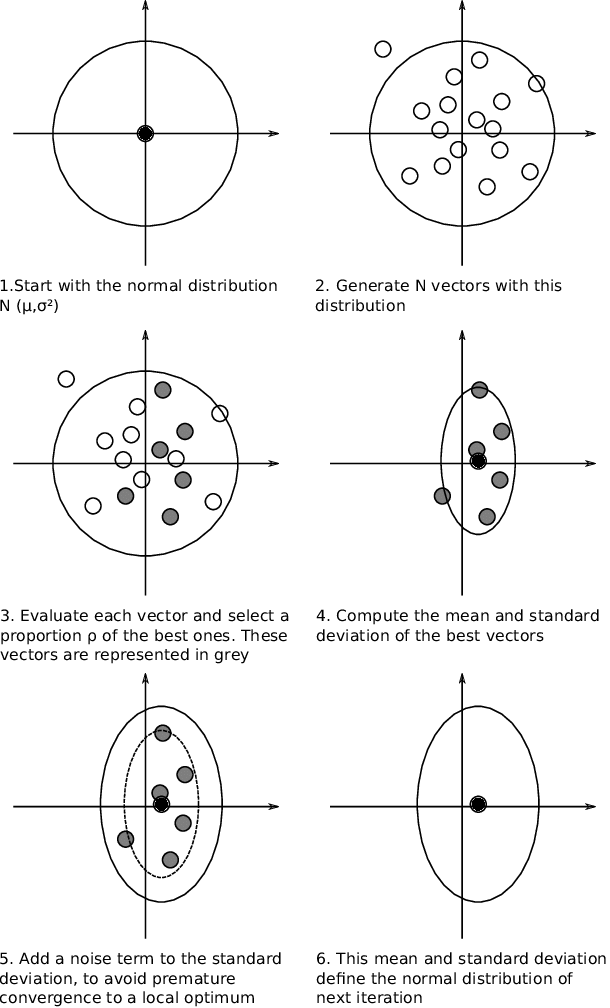

## Homework

In the above model for CartPole, try to modify the model to experiment new ideas. 

Requirements:
1. Use cross-entropy method. 
2. Change NN to have more or less neurons, more layers, different activation functions, different optimizer, learning rate. How does it impact the results.
3. Change BATCH_SIZE and PERCENTILE. How does it impact the results.
4. New rule in this game: you must run your same action twice in every step before the agent receives the observation and chooses next action. Modify and train your model. Show the results and discuss the difference.
5. ExteBuild another NN to use one observation to generate two consecutive actions. You will have 4 possible outputs: LL, LR, RL, RR. Then you will apply the two consecutive actions in the environment and then receive the last observation to predict next two consecutive actions. Train the model and show your resultnd from above.

Your grade is based on the completeness. 

Submit in BOTH ipynb and html formats. 